# Labwork 7: Grayscale stretch

In [7]:
IMAGE_FILE = "natalie.jpg"

## Visualize the image

In [8]:
import matplotlib.pyplot as plt

def show_image(image, title=None, vmax=255):
  if isinstance(image, str):
    image = plt.imread(image)

  height, width, channels = image.shape
  print(f"Size of image: {width} x {height} - {height * width} pixels - channel {channels}")

  plt.imshow(image, cmap='gray', vmin=0, vmax=vmax)
  plt.axis('off')
  plt.title(title, fontweight ="bold")
  plt.show()

Size of image: 640 x 427 - 273280 pixels - channel 3


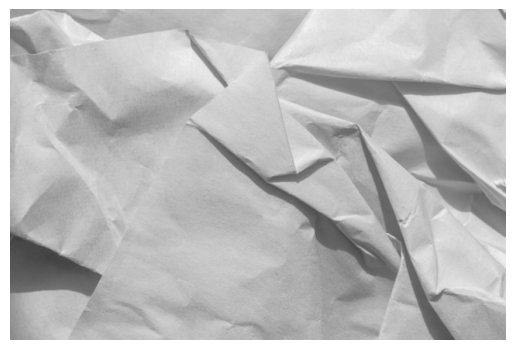

In [9]:
show_image(IMAGE_FILE)

## Grayscale Stretch

In [32]:
from numba import cuda
import numba
import numpy as np
import time


@cuda.jit
def grayscale(src, dst, h, w):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx >= w or tidy >= h:
    return

  g = np.uint8((src[tidy, tidx, 0] + src[tidy, tidx, 1] + src[tidy, tidx, 2]) / 3)
  dst[tidy, tidx, 0] = dst[tidy, tidx, 1] = dst[tidy, tidx, 2] = g


@cuda.jit
def find_min_max_intensity(src, dst):
  localtid_x = cuda.threadIdx.x
  localtid_y = cuda.threadIdx.y
  tidx = localtid_x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = localtid_y + cuda.blockIdx.y * cuda.blockDim.y
  blockSize = 64*64
  localtid = localtid_y * cuda.blockDim.y + localtid_x

  # Share memory declaration
  min_img = cuda.shared.array((blockSize, ), np.uint8)
  max_img = cuda.shared.array((blockSize, ), np.uint8)

  # == 1. Copy to cache
  min_img[localtid_y * cuda.blockDim.y + localtid_x] = np.uint8(src[tidy][tidx][0])
  max_img[localtid_y * cuda.blockDim.y + localtid_x] = np.uint8(src[tidy][tidx][0])
  cuda.syncthreads()

  # == 2. Find the min, max intensity
  s = int(blockSize / 2)
  while s > 0:
    if (localtid < s):
      min_img[localtid] = min(min_img[localtid], min_img[localtid + s])
      max_img[localtid] = max(max_img[localtid], max_img[localtid + s])
    cuda.syncthreads()
    s = s // 2

  if localtid == 0:
    dst[cuda.blockIdx.y][cuda.blockIdx.x][0] = min_img[0]
    dst[cuda.blockIdx.y][cuda.blockIdx.x][1] = max_img[0]


@cuda.jit
def recalculate_intensity(src, dst, h, w, min_val, max_val):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx >= w or tidy >= h:
    return

  g = np.uint8((src[tidy, tidx, 0] + src[tidy, tidx, 1] + src[tidy, tidx, 2]) // 3)
  g = np.uint8(np.float32(g - min_val) / (max_val - min_val) * 255)
  dst[tidy, tidx, 0] = dst[tidy, tidx, 1] = dst[tidy, tidx, 2] = g


def grayscale_stretch(image_file, blockSize=(32, 32)):
  img = plt.imread(image_file)
  imageHeight, imageWidth = img.shape[0], img.shape[1]
  gridSize = (
    (imageWidth + blockSize[1] - 1) // blockSize[1],
    (imageHeight + blockSize[0] - 1) // blockSize[0],
  )

  gridSize_lossly = (imageWidth // blockSize[1], imageHeight // blockSize[0])

  print(f"Do grayscale stretch image by gpu, blockSize={blockSize} ...")

  start_t = time.time()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)
  grayscale[gridSize, blockSize](devSrc, devDst, imageHeight, imageWidth)
  img = devDst.copy_to_host()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((gridSize[0], gridSize[1], 2), np.uint8)
  find_min_max_intensity[gridSize_lossly, blockSize](devSrc, devDst)
  min_max = devDst.copy_to_host()

  min_value = np.min(min_max[:, [0]])
  max_value = np.max(min_max[:, [1]])
  print(min_value, max_value)

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)
  recalculate_intensity[gridSize, blockSize](devSrc, devDst, imageHeight, imageWidth, min_value, max_value)
  img = devDst.copy_to_host()

  total_time = time.time() - start_t
  print(f"It took {total_time} seconds to finish.")

  return img, total_time


Do grayscale stretch image by gpu, blockSize=(32, 32) ...
0 236
It took 0.49784183502197266 seconds to finish.
Size of image: 640 x 427 - 273280 pixels - channel 3


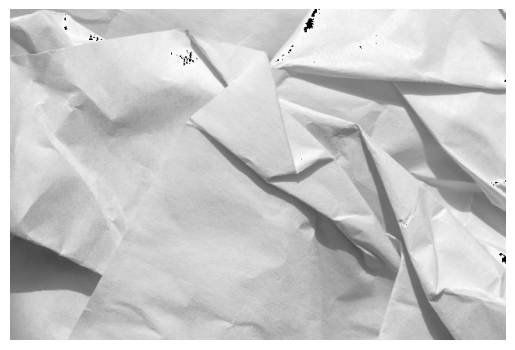

In [33]:
out_img, _ = grayscale_stretch(IMAGE_FILE, (32, 32))

show_image(out_img)

## Experiment with diﬀerent 2D block size values

Do grayscale image by gpu, blockSize=(8, 8) ...
0 234
It took 0.007851123809814453 seconds to finish.
Do grayscale image by gpu, blockSize=(8, 8) ...
0 234
It took 0.009184598922729492 seconds to finish.
Do grayscale image by gpu, blockSize=(16, 16) ...
0 225
It took 0.008015871047973633 seconds to finish.
Do grayscale image by gpu, blockSize=(32, 32) ...
58 229
It took 0.005582571029663086 seconds to finish.


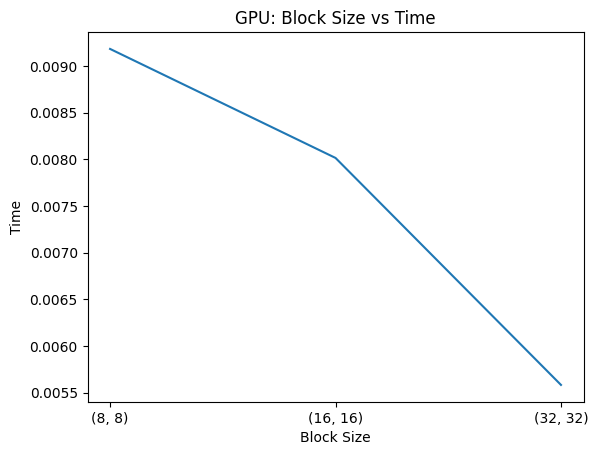

In [6]:
import matplotlib.pyplot as plt

# Process in 2D grid
block_sizes = [
   (8, 8), (8, 8), (16, 16), (32, 32),
]

process_times = []

for block_size in block_sizes:
  _, total_time = grayscale_stretch(IMAGE_FILE, block_size)
  process_times.append(total_time)

# Plot a graph of block size vs time
x_labels = [str(dim) for dim in block_sizes[1:]]
plt.plot(x_labels, process_times[1:], label="binarization")

plt.title('GPU: Block Size vs Time')
plt.xlabel('Block Size')
plt.ylabel('Time')
plt.show()
